# Materials Project Formation Energy Distribution

MP has a curious bimodality in its formation energies. Considering the formation energies are the result of a carefully fitted correction scheme (see `pymatgen.entries.compatibility.MaterialsProject2020Compatibility`) that takes into account only the composition of a compound, let's look at which elements dominate the upper and lower modes.

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
from pymatgen.ext.matproj import MPRester

from pymatviz import count_elements, ptable_heatmap_plotly


__author__ = "Janosh Riebesell"
__date__ = "2022-08-11"

pio.templates.default = "plotly_white"
# Comment out next line to get interactive plotly figures. Only used here since
# interactive figures don't show up at all in notebooks on GitHub.
# https://github.com/plotly/plotly.py/issues/931
pio.renderers.default = "png"

/Users/janosh/dev/pmg/pymatgen/analysis/phase_diagram.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# %% 2022-08-11 check if all of MP also has a bi-modal formation energy distribution
# answer, yes it does
e_form_all_mp = MPRester().query(
    {}, ["material_id", "formula", "formation_energy_per_atom"]
)

df_e_form_all_mp = pd.DataFrame(e_form_all_mp).set_index("material_id")

In [ ]:
# cache MP data
# %store df_e_form_all_mp

# load cached MP data
%store -r df_e_form_all_mp

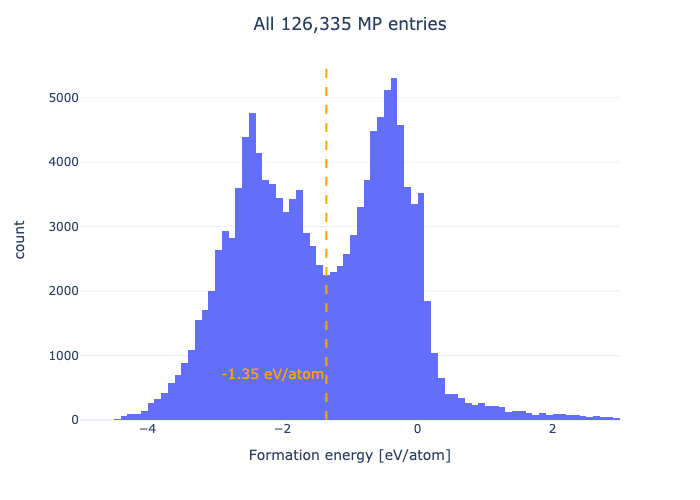

In [ ]:
labels = {"formation_energy_per_atom": "Formation energy [eV/atom]"}
fig = px.histogram(
    df_e_form_all_mp,
    x="formation_energy_per_atom",
    nbins=200,
    range_x=(-5, 3),
    labels=labels,
)

e_form_valley = -1.35
fig.add_vline(e_form_valley, line=dict(color="orange", dash="dash"))
fig.add_annotation(
    text=f"{e_form_valley} eV/atom",
    x=e_form_valley - 0.8,
    y=0.1,
    yref="paper",
    font=dict(size=14, color="orange"),
    showarrow=False,
)
fig.update_layout(title=dict(text=f"All {len(df_e_form_all_mp):,} MP entries", x=0.5))

First, let's plot elemental prevalence as a heatmap over the periodic table for things above and below `e_form_valley`.

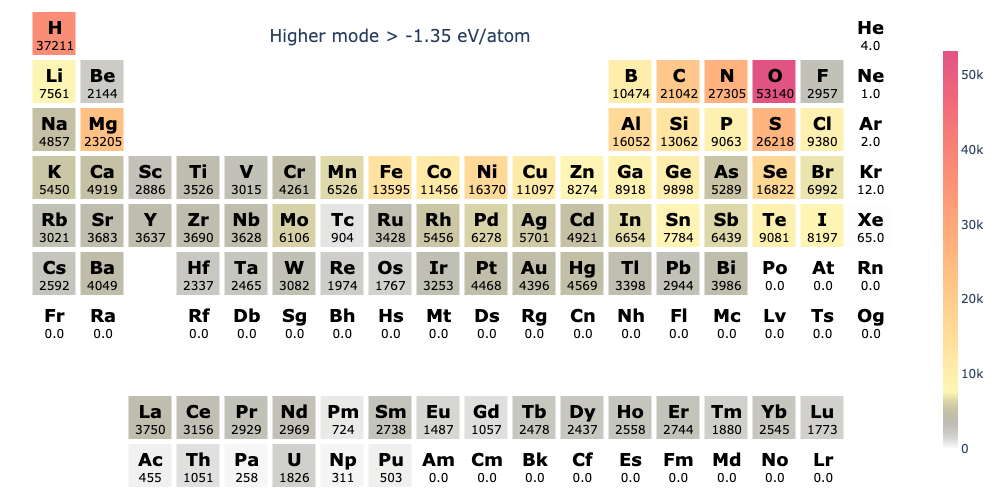

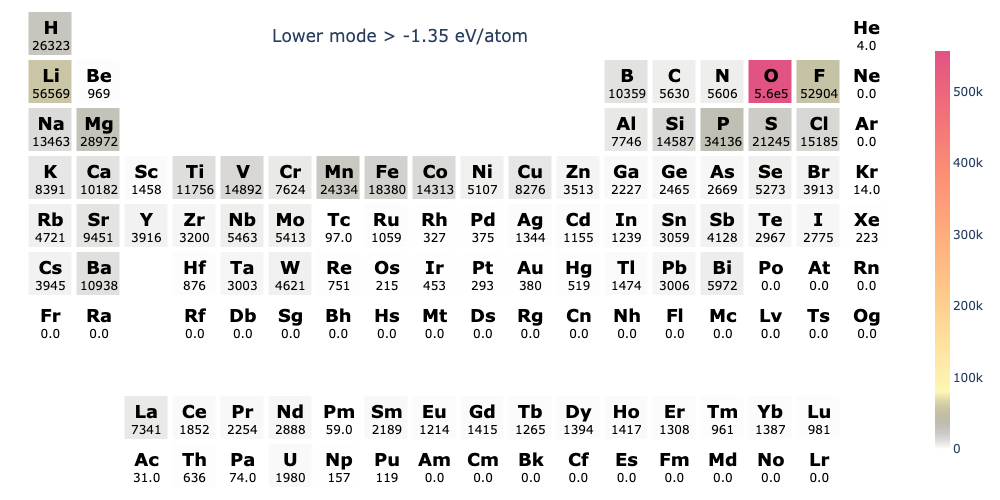

In [ ]:
for comparator, label in ((">", "higher"), ("<=", "lower")):

    fig = ptable_heatmap_plotly(
        df_e_form_all_mp.query(
            f"formation_energy_per_atom {comparator} {e_form_valley}"
        ).formula
    )
    fig.update_layout(
        title=dict(
            text=f"{label.title()} mode > {e_form_valley} eV/atom", x=0.4, y=0.94
        )
    )
    fig.show()

Looks like the lower mode is mostly oxides, whereas the higher mode is more diverse also containing many nitrides, sulfides and selenides.

Another way to visualize this are bar charts.

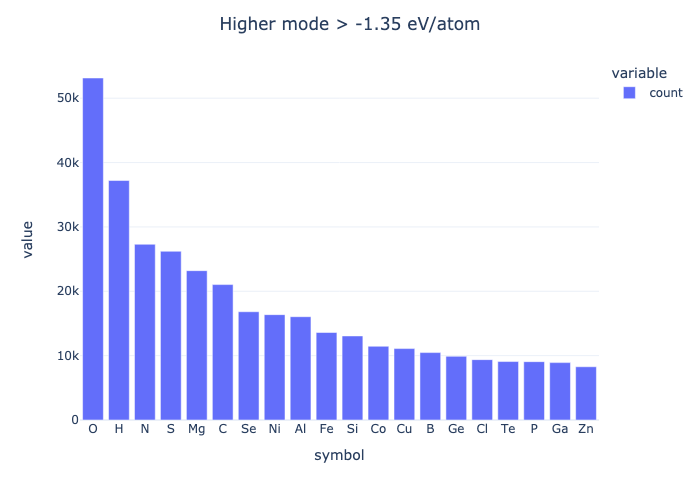

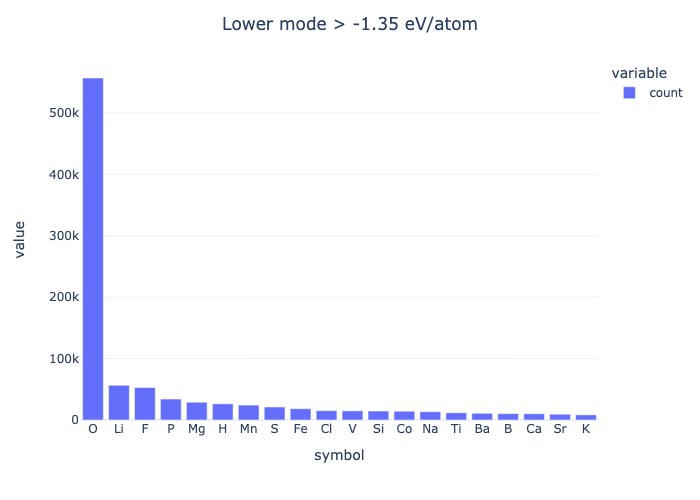

In [ ]:
for comparator, label in ((">", "higher"), ("<=", "lower")):
    elem_counts = count_elements(
        df_e_form_all_mp.query(
            f"formation_energy_per_atom {comparator} {e_form_valley}"
        ).formula
    )
    elem_counts = count_elements(
        df_e_form_all_mp.query(
            f"formation_energy_per_atom {comparator} {e_form_valley}"
        ).formula
    )
    fig = px.bar(elem_counts.nlargest(20))
    title = f"{label.title()} mode > {e_form_valley} eV/atom"
    fig.update_layout(title=dict(text=title, x=0.5))
    fig.show()

Note that this significant lowering of oxide formation energies compared to other anions might at least partially be an artifact of too little experimental data outside oxide systems. In other words, perhaps there should be stronger corrections applied to nitrides, selenides, etc. as well but because there's insufficient experimental data to fit a robust correction scheme there, MP doesn't.